In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
pd.options.mode.chained_assignment = None  # default='warn', this is for SettingWithCopyWarning

/opt/anaconda3/envs/mitdcc/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('slurm-log.csv')

df['duration'] = df['time_end'] - df['time_start']

# Some rows were completely blank, this got rid of them.
df = df.dropna(axis=0, subset=['time_start'])

# Change unix time to datetime
df['actual_time'] = pd.to_numeric(
pd.to_datetime(df['time_start'], unit='s', utc=True).dt.tz_convert(tz='US/Eastern'))
print(df.columns)

df_corr = df[['cpus_req', 'mem_req', 'priority', 'state', 'timelimit', 'time_start', 'duration', 'actual_time']]
df_corr = df_corr.dropna()

# # These two columns below have text in them for some reason, deleting rows that have the text in them
# df_corr = df_corr[df_corr.cpus_req.apply(lambda x: x.isnumeric())]
# df_corr = df_corr[df_corr.mem_req.apply(lambda x: x.isnumeric())]

# They columns still have Dtype as object, so I changed them to numerical, to have int64 and uint64, respectively
df_corr["cpus_req"] = pd.to_numeric(df_corr["cpus_req"])
df_corr["mem_req"] = pd.to_numeric(df_corr["mem_req"])

print(df_corr.info())

# Getting rid of upper echelon (1 Exbibyte and (2^32)-1)
df_adj = df_corr[df_corr['timelimit'] < 1000000]
df_adj = df_corr[df_corr['mem_req'] < 1000000]

Index(['id_job', 'id_array_job', 'id_array_task', 'id_user', 'kill_requid',
       'nodes_alloc', 'nodelist', 'cpus_req', 'derived_ec', 'exit_code',
       'gres_used', 'array_max_tasks', 'array_task_pending', 'constraints',
       'flags', 'mem_req', 'partition', 'priority', 'state', 'timelimit',
       'time_submit', 'time_eligible', 'time_start', 'time_end',
       'time_suspended', 'track_steps', 'tres_alloc', 'tres_req', 'job_type',
       'duration', 'actual_time'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395914 entries, 0 to 395913
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   cpus_req     395914 non-null  int64 
 1   mem_req      395914 non-null  uint64
 2   priority     395914 non-null  int64 
 3   state        395914 non-null  int64 
 4   timelimit    395914 non-null  int64 
 5   time_start   395914 non-null  int64 
 6   duration     395914 non-null  int64 
 7   actual_t

In [3]:
# Multiple Regression
x = df_adj.drop(['duration'], axis=1)
y = df_adj['duration']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.7, random_state=0)

ml = LinearRegression()
ml.fit(x_train, y_train)

y_pred = ml.predict(x_test)
print(y_pred)
print(r2_score(y_test, y_pred))

[23001.49087641  3190.38935303  9078.23760468 ...  8237.88532481
  9103.23789458  5413.53131158]
0.08617253334814501


In [4]:
# Stats model
x_train_Sm = sm.add_constant(x_train)
ls = sm.OLS(y_train, x_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     179.7
Date:                Tue, 23 Aug 2022   Prob (F-statistic):          1.82e-114
Time:                        15:23:24   Log-Likelihood:            -1.8244e+05
No. Observations:               14744   AIC:                         3.649e+05
Df Residuals:                   14740   BIC:                         3.649e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.303e-09   1.02e-09      1.281      

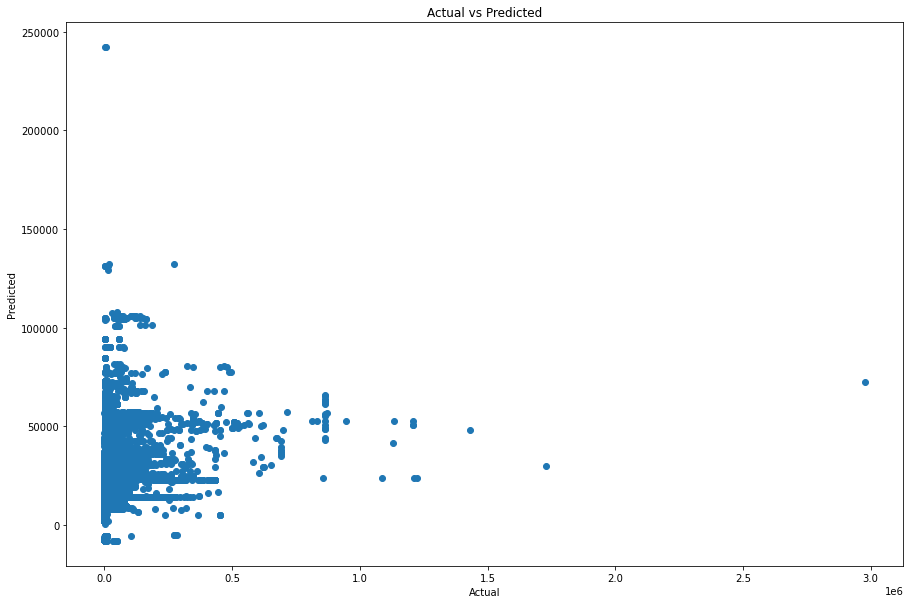

        Actual  Predicted  Difference
251144  432948   23001.49   409946.51
39169     1217    3190.39    -1973.39
11332      383    9078.24    -8695.24
75110     1995   16046.37   -14051.37
28789      431   -8058.14     8489.14
48701     1026    8593.86    -7567.86
291393   20811   18883.13     1927.87
362110    1334   39869.71   -38535.71
136857  155386   67857.16    87528.84
21622      419   15345.92   -14926.92
11324      383    9078.24    -8695.24
14646      668    9102.01    -8434.01
328310     508   25922.27   -25414.27
49052     1018   11198.20   -10180.20
43520    14411   12273.16     2137.84
8404       416    9074.06    -8658.06
28777      368   -8058.14     8426.14
387973     486   14947.10   -14461.10
39138     1179    3190.24    -2011.24
215685    5014   19401.60   -14387.60


In [5]:
# Plotting to see how good or bad this is... its bad
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

pred_y_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Difference': y_test - y_pred})
pd.options.display.float_format = '{:.2f}'.format
print(pred_y_df[0:20])

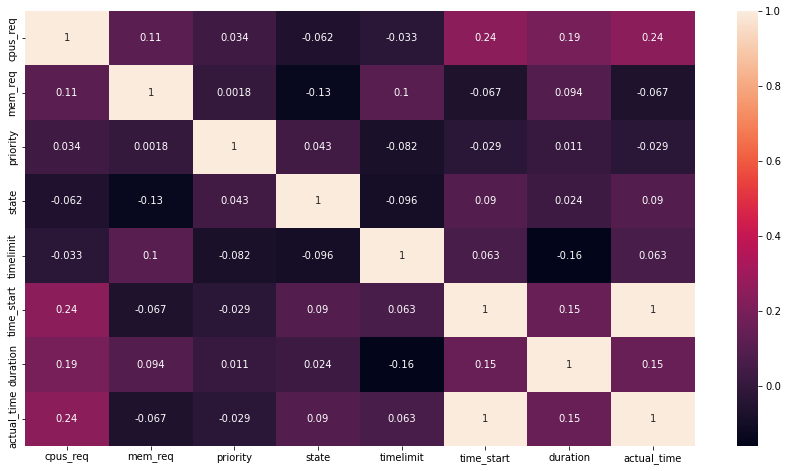

In [6]:
# Time to see the correlation
fig = plt.figure(figsize =(15,8), label = 'Correlation')
sns.heatmap(df_adj.corr(),annot= True)
plt.show()

<AxesSubplot:xlabel='actual_time'>

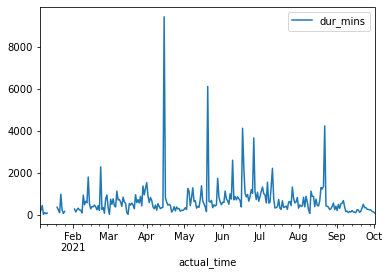

In [8]:
# Plotting average job duration (in minutes) per date started using columns from before lines 30-31 were ran
df_corr['actual_time'] = pd.to_datetime(df_corr['actual_time'])
df_date = df_corr[['actual_time', 'duration']]
df_date['dur_mins'] = df_date['duration'] / 60
df_date = df_date.dropna()
df_date = df_date.set_index('actual_time').resample('D').mean()
# This varies a good bit when we use df_adj instead of df_corr values
df_date.reset_index().plot(kind='line', x='actual_time', y='dur_mins')

            id_user   dur_mins
104  14874030010043      5.183
400  60341133311302      5.267
160  22404620230279      5.417
61    8922460967822      6.207
320  45487591934198      6.754
..              ...        ...
474  72724016675242  8,557.169
282  39054361948168 10,296.989
561  85841110647824 10,575.628
290  40179146688035 13,548.331
94   14160337908170 20,478.587

[608 rows x 2 columns]
count      608.000
mean       800.944
std      1,488.613
min          5.183
25%        148.520
50%        445.987
75%        820.989
max     20,478.587
Name: dur_mins, dtype: float64


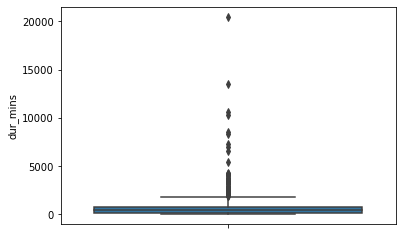

In [9]:
# Average duration (in minutes) by user... maybe do a box and whisker plot for them?
df_user = df[['id_user', 'duration']]
df_user['dur_mins'] = df_user['duration']/60
df_user = df_user.dropna()
df_user = df_user.groupby(['id_user'])['dur_mins'].mean().reset_index()
df_user = df_user.sort_values(by=['dur_mins'])
pd.options.display.float_format = '{:3,.3f}'.format
print(df_user)
print(df_user['dur_mins'].describe())

# Here is the box and whisker plot... a lot of outliers here... Zoom in when showing the plot
sns.boxplot(y=df_user["dur_mins"])
plt.show()